In [1]:
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import evaltools as et, viz_tools
import cmocean as cmo
import datetime as dt
import netCDF4 as nc
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import cmocean
import pandas as pd
import pickle
import os
import gsw

%matplotlib inline

#### definitions for matching model output

In [2]:
# path to model files:
PATH= '/results/SalishSea/nowcast-green.201812/'

# start and end dates for analysis:
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2016,1,1)

# number of days per model file:
flen=1

# dictionary mapping desired model variables to the file types where they are found
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T',
         'flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}

# dictionary mapping model file types to their time resolution in hours (1 is hourly files, 24 is daily)
fdict={'ptrc_T':1,'grid_T':1}

# results format
# -- nowcast: files like 01jan15/SalishSea_1h_20150101_20150101_ptrc_T.nc
# -- long: files like SalishSea_1h_20150206_20150804_ptrc_T_20150427-20150506.nc, all in one directory
namfmt='nowcast'


### load WADE nutrient data and create csv file

In [3]:
def interpCTDvar(sta,yr,yd,ztarget,ctdvar):
    ctdlocs=(dfCTD.Station==sta)&(dfCTD.Year==yr)&(dfCTD.YD==yd)
    if np.sum(ctdlocs)==0:
        print(f'Warning: Station {sta}, Year {yr}, year day {yd} not found in dfCTD')
        return np.nan
    else:
        val=np.interp(ztarget,dfCTD.loc[ctdlocs,['Z']].values.flatten(),
                  dfCTD.loc[ctdlocs,[ctdvar]].values.flatten())
        return val

In [4]:
# load new datetime info
dfTime=pd.read_excel('/ocean/eolson/MEOPAR/obs/WADE/WDE_Data/OlsonSuchyAllen_UBC_PDR_P003790-010721.xlsx',
                    engine='openpyxl',sheet_name='EventDateTime')
# drop duplicate rows, taking first time
dfTime.drop_duplicates(subset=['FlightDate','SiteCode'],keep='first',inplace=True)
dfTime['dtPac']=[dt.datetime.combine(idate, itime) for idate, itime \
         in zip(dfTime['FlightDate'],dfTime['TimeDown \n(Local - PST or PDT)'])]
dfTime['dtUTC']=[et.pac_to_utc(ii) for ii in dfTime['dtPac']]
# join to date/time
dfTime['dtUTC']=[et.pac_to_utc(dt.datetime.combine(idate,itime)) for idate,itime in \
                zip(dfTime['FlightDate'],dfTime['TimeDown \n(Local - PST or PDT)'])]
dfTime2=dfTime.loc[:,['FlightDate','SiteCode','dtUTC']]

In [5]:
dfs=dict()
for year in range(2015,2019):
    PATH= '/results2/SalishSea/nowcast-green.201905/'
    datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'
    dfSta=pickle.load(open(os.path.join(datadir,'sta_df.p'),'rb'))
    dfCTD0=pickle.load(open(os.path.join(datadir,f'Casts_{str(year)}.p'),'rb'))
    dfs0=pd.merge(left=dfSta,right=dfCTD0,how='right',
             left_on='Station',right_on='Station')
    dfs0.rename(columns={'Latitude':'Lat','Longitude':'Lon'},inplace=True)
    # Calculate Absolute (Reference) Salinity (g/kg) and Conservative Temperature (deg C) from 
    # Salinity (psu) and Temperature (deg C):
    dfs0['Z']=-1*dfs0['Z']
    press=gsw.p_from_z(-1*dfs0['Z'],dfs0['Lat'])
    dfs0['SA']=gsw.SA_from_SP(dfs0['Salinity'],press,
                               dfs0['Lon'],dfs0['Lat'])
    dfs0['CT']=gsw.CT_from_t(dfs0['SA'],dfs0['Temperature'],press)
    # merge time
    dfs[year]=pd.merge(left=dfs0,right=dfTime2,how='left',
                      left_on=['Date','Station'],right_on=['FlightDate','SiteCode'])
    # if no time available, guess midday
    dfs[year]['dtUTC']=[iiD+dt.timedelta(hours=20) if pd.isnull(iiU) else iiU \
                    for iiU,iiD in zip(dfs[year]['dtUTC'],dfs[year]['Date'])]
    #dfs[year]['Year']=[ii.year for ii in dfs[year]['dtUTC']]
    #dfs[year]['YD']=et.datetimeToYD(dfs[year]['dtUTC'])

In [6]:
dfAll=pd.concat((dfs[2015],dfs[2016],dfs[2017],dfs[2018]))
dfAll.drop(columns=['Desig','Descrip','Date','Max_Depth','Salinity','Temperature','FlightDate','DO','Turb'],inplace=True)
dfAll

,Station,Basin,Lat,Lon,Sigma,Chl,Z,SA,CT,SiteCode,dtUTC
0,ADM001,Admiralty Inlet,48.029813,-122.617933,23.311800,0.809025,118.5,30.307274,9.191911,ADM001,2015-01-20 19:14:00
1,ADM001,Admiralty Inlet,48.029813,-122.617933,23.310699,0.829323,118.0,30.305957,9.192287,ADM001,2015-01-20 19:14:00
2,ADM001,Admiralty Inlet,48.029813,-122.617933,23.306700,0.791626,117.5,30.301120,9.193727,ADM001,2015-01-20 19:14:00
3,ADM001,Admiralty Inlet,48.029813,-122.617933,23.304600,0.791626,117.0,30.298496,9.194526,ADM001,2015-01-20 19:14:00
4,ADM001,Admiralty Inlet,48.029813,-122.617933,23.306299,0.817724,116.5,30.300392,9.193442,ADM001,2015-01-20 19:14:00
...,...,...,...,...,...,...,...,...,...,...,...
55880,WPA113,Willapa Bay,46.644000,-123.993000,22.316300,NaN,3.0,29.307299,10.628845,NaN,2018-11-19 20:00:00
55881,WPA113,Willapa Bay,46.644000,-123.993000,22.249900,NaN,2.5,29.220695,10.627059,NaN,2018-11-19 20:00:00
55882,WPA113,Willapa Bay,46.644000,-123.993000,22.152100,NaN,2.0,29.092593,10.620385,NaN,2018-11-19 20:00:00
55883,WPA113,Willapa Bay,46.644000,-123.993000,22.115000,NaN,1.5,29.043971,10.617901,NaN,2018-11-19 20:00:00


In [7]:
dfAll.keys()

Index(['Station', 'Basin', 'Lat', 'Lon', 'Sigma', 'Chl', 'Z', 'SA', 'CT',
       'SiteCode', 'dtUTC'],
      dtype='object')

In [8]:

dfAll.to_csv('/data/eolson/results/MEOPAR/oldDBs/WADECTD.csv',index=False)

### load csv file

In [9]:
df2=pd.read_csv('/data/eolson/results/MEOPAR/oldDBs/WADECTD.csv')
# convert dtUTC back to datetime
df2['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') for ii in df2['dtUTC']]
print(len(df2))
df2.head()

211283


,Station,Basin,Lat,Lon,Sigma,Chl,Z,SA,CT,SiteCode,dtUTC
0,ADM001,Admiralty Inlet,48.029813,-122.617933,23.311800,0.809025,118.5,30.307274,9.191911,ADM001,2015-01-20 19:14:00
1,ADM001,Admiralty Inlet,48.029813,-122.617933,23.310699,0.829323,118.0,30.305957,9.192287,ADM001,2015-01-20 19:14:00
2,ADM001,Admiralty Inlet,48.029813,-122.617933,23.306700,0.791626,117.5,30.301120,9.193727,ADM001,2015-01-20 19:14:00
3,ADM001,Admiralty Inlet,48.029813,-122.617933,23.304600,0.791626,117.0,30.298496,9.194526,ADM001,2015-01-20 19:14:00
4,ADM001,Admiralty Inlet,48.029813,-122.617933,23.306299,0.817724,116.5,30.300392,9.193442,ADM001,2015-01-20 19:14:00


In [10]:
# match model output to observations and return both in a dataframe
# the model variables will have their original names prefixed by mod_, eg mod_vosaline
# the observation file names are unchanged. 
data=et.matchData(data=df2,filemap=filemap, fdict=fdict, mod_start=start_date, mod_end=end_date, 
                  mod_nam_fmt=namfmt, mod_basedir=PATH, mod_flen=flen)

ferry
(Lat,Lon)= 46.453154999999995 -124.00960333333332  not matched to domain
(Lat,Lon)= 46.463155 -123.94126833333334  not matched to domain
(Lat,Lon)= 46.54537666666667 -123.98016166666666  not matched to domain
(Lat,Lon)= 46.644 -123.993  not matched to domain
(Lat,Lon)= 46.68676333333333 -123.9735  not matched to domain
(Lat,Lon)= 46.70398666666666 -123.83738500000001  not matched to domain
(Lat,Lon)= 46.93731333333334 -123.91322333333332  not matched to domain
(Lat,Lon)= 46.953421666666664 -124.09295  not matched to domain
(Lat,Lon)= 47.21342666666666 -123.07765  not matched to domain
progress: 0.0%
progress: 9.23395139247987%
progress: 18.46790278495974%
progress: 27.70185417743961%
progress: 36.93580556991948%
progress: 46.16975696239935%
progress: 55.40370835487922%
progress: 64.6376597473591%
progress: 73.87161113983896%
progress: 83.10556253231883%
progress: 92.3395139247987%


In [11]:
#Chl:N ratio used later in plots: grab from appropriate namelist
mod_chl_N=et.getChlNRatio(basedir=PATH,nam_fmt=namfmt)

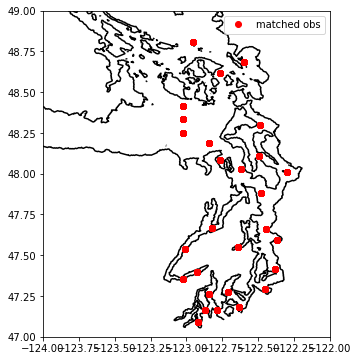

In [20]:
# plot matched data locations
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='matched obs')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, isobath=.001,coords = 'map')
ax.set_ylim(47, 49)
ax.legend()
ax.set_xlim(-124, -122);

In [13]:
# create dictionary of dataframe views by year
datyr=dict()
yy=np.array([ii.year for ii in data['dtUTC']])
yys=np.unique(yy)
for yr in yys:
    datyr[yr]=data.loc[yy==yr]

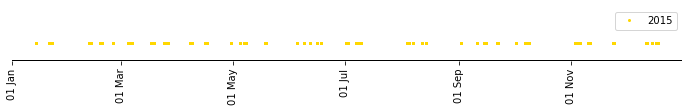

In [14]:
# plot matched data sampling times
clist=('gold','aqua','plum','c','m','r','g','b','brown','gray')
fig,axL=plt.subplots(1,1,figsize=(12,1))
for ii, yr in enumerate(yys):
    dshift=dt.datetime(yys[0],1,1)-dt.datetime(yr,1,1)
    axL.plot(datyr[yr].dtUTC+dshift,np.zeros(np.shape(datyr[yr].dtUTC))+.1*ii,'.',
             color=clist[ii],markersize=4,label=str(yr))
axL.set_yticks(());
yearsFmt = mdates.DateFormatter('%d %b')
axL.xaxis.set_major_formatter(yearsFmt)
axL.xaxis.set_ticks([dt.datetime(int(yys[0]),1,1), dt.datetime(int(yys[0]),3,1),dt.datetime(int(yys[0]),5,1),dt.datetime(int(yys[0]),7,1),
                     dt.datetime(int(yys[0]),9,1),dt.datetime(int(yys[0]),11,1),dt.datetime(int(yys[0])+1,1,1)])
for tick in axL.get_xticklabels():
        tick.set_rotation(90)
        tick.set_horizontalalignment('center')
axL.set_ylim(-.1,.1*(len(datyr.keys())+1))
axL.set_xlim(dt.datetime(yys[0],1,1),dt.datetime(yys[0],12,31))
axL.legend()
axL.set_frame_on(False)
xmin, xmax = axL.get_xaxis().get_view_interval()
ymin, ymax = axL.get_yaxis().get_view_interval()
axL.add_artist(mpl.lines.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

#### Display stats

In [22]:
print('SA depth<15:') 
et.printstats(data.loc[data.Z<15,:],'SA','mod_vosaline')
print('CT depth<15:')
et.printstats(data.loc[data.Z<15,:],'CT','mod_votemper')

SA depth<15:
  N: 7910
  bias: -0.5188559311472289
  RMSE: 1.5541583492257305
  WSS: 0.8354347128369622
CT depth<15:
  N: 7910
  bias: 0.03851665034366292
  RMSE: 0.8894992822008563
  WSS: 0.9629385874655843


### mod vs. obs plots

Text(0.5, 1.0, 'SA (g/kg)')

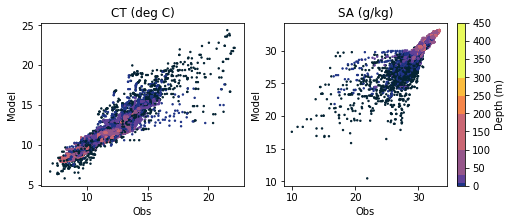

In [24]:
cm1=cmocean.cm.thermal
bounds = np.array([0,5,10,35,100,200,250,300,450])
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#pcm = ax[1].pcolormesh(X, Y, Z1, norm=norm, cmap='RdBu_r')
fig,ax=plt.subplots(1,2,figsize=(8,3))
args={'marker':'.','s':8,'norm':norm}
ps=et.varvarScatter(ax[0],data,'CT','mod_votemper','Z',cm=cm1,args=args)
ps=et.varvarScatter(ax[1],data,'SA','mod_vosaline','Z',cm=cm1,args=args)

cb=fig.colorbar(ps,ax=ax[1],boundaries=np.linspace(0,450,46))
cb.set_label('Depth (m)')
for iax in ax:
    iax.set_ylabel('Model')
    iax.set_xlabel('Obs')
ax[0].set_title('CT (deg C)')
ax[1].set_title('SA (g/kg)')
